In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# GPU implement

## Build a simple model

In [ ]:
net = nn.Sequential(
    nn.Linear(20,100),
    nn.ReLU(),
    nn.Linear(100,500),
    nn.ReLU(),
    nn.Linear(500,30),
    nn.ReLU(),
    nn.Linear(30,2),
)

## Make some data

In [ ]:
# just some random fluff
data = torch.randn((1000,20)) # samples X features
labels = torch.randint(low=0, high=2, size=(1,1000))

## Send the model and the data to the GPU

In [ ]:
# model
net.to(device)

# data
data = data.to(device)
labels = labels.to(device)

In [ ]:
data

tensor([[-1.4609, -0.4967,  1.6873,  ...,  0.2614, -0.4718, -1.0691],
        [ 1.9973, -1.1588, -0.0095,  ..., -0.2363,  0.9308, -0.4221],
        [ 0.4355,  0.0541,  0.7231,  ..., -0.6153,  1.0629, -0.3763],
        ...,
        [-0.3812, -0.3532, -1.7057,  ..., -1.1358,  0.5700, -1.1765],
        [ 0.3309, -0.3925,  0.5727,  ...,  1.9626,  0.2171, -2.0152],
        [-0.0324, -0.0972, -0.4525,  ..., -0.0093,  0.0164, -1.4951]],
       device='cuda:0')

In [ ]:
# you can also create data directly on the GPU
dataG = torch.randn((1000,20), device=device)
dataC = torch.randn((1000,20), device='cpu')

print(data.device)
print(dataG.device)
print(dataC.device)

cuda:0
cuda:0
cpu


## Getting results from the model

In [ ]:
output = net(data)

In [ ]:
output.device

device(type='cuda', index=0)

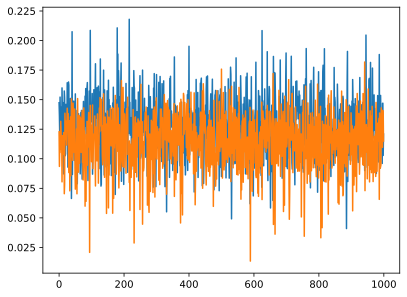

In [ ]:
# try to plot the data
# plt.plot(output.detach());

plt.plot(output.detach().cpu());

## Experiment: Computation time

In [ ]:
# start the clock
starttime = time.process_time()

# move, run, retrieve
device = 'cuda:0'
net.to(device)
data = data.to(device)
labels = labels.to(device)
output = net(data).detach().cpu()

# stop the clock
GPUtime = 1000 * (time.process_time() - starttime)

In [ ]:
# start the clock
starttime = time.process_time()

# move, run, retrieve
device = 'cpu'
net.to(device)
data = data.to(device)
labels = labels.to(device)
output = net(data).detach().cpu()

# stop the clock
CPUtime = 1000 * (time.process_time() - starttime)

In [ ]:
# time in ms
[CPUtime, GPUtime]

[10.138354999995158, 3.457875999998805]

In [ ]:
# but maybe "sending" it to the CPU takes too much overhead?

In [ ]:
# recreate network and data
net = nn.Sequential(
    nn.Linear(20,100),
    nn.ReLU(),
    nn.Linear(100,500),
    nn.ReLU(),
    nn.Linear(500,30),
    nn.ReLU(),
    nn.Linear(30,2)
)
data = torch.randn((1000,20))

# rerun the experiment
starttime = time.process_time()
output = net(data).detach()
CPUtime2 = 1000 * (time.process_time() - starttime)

# report the results
[CPUtime2, CPUtime, GPUtime]

[5.393489999995893, 10.138354999995158, 3.457875999998805]

# Run an experiment on the GPU

## import and process the data

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:,0]
data = data[:,1:]

dataNorm = data / np.max(data)

## Create train/test groups using DataLoader

In [ ]:
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [ ]:
def createTheMNISTNet(nUnits, nLayers):

    class mnistNet(nn.Module):
        def __init__(self, nUnits, nLayers):
            super().__init__()

            # create dictionary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            # input layer
            self.layers['input'] = nn.Linear(784, nUnits)

            # hidden layers
            for i in range(nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

            # output layer
            self.layers['output'] = nn.Linear(nUnits, 10)

        def forward(self, x):
            # input layer
            x = F.relu( self.layers['input'](x) )

            # hidden layers
            for i in range(self.nLayers):
                x = F.relu( self.layers[f'hidden{i}'](x) )

            # return output layer
            x = self.layers['output'](x)
            return F.log_softmax(x, dim=1)

    # create the model instance
    net = mnistNet(nUnits, nLayers)

    # loss function
    lossfunc = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

In [ ]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer, nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## Create a function that trains the model

In [ ]:
def function2trainTheModel(nUnits, nLayers):

    numepochs = 60

    # create a new model
    net, lossfunc, optimizer = createTheMNISTNet(nUnits, nLayers)

    # NEW!
    net.to(device)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # NEW!
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # NEW! bring outputs back
            yHat = yHat.cpu()
            y = y.cpu()

            # batch accuracy
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))

        # NEW!
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = net(X)

        # NEW! bring outputs back
        yHat = yHat.cpu()
        y = y.cpu()

        # test accuracy
        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    # function output
    return trainAcc, testAcc, losses, net

In [ ]:
# test the model once to make sure it works
trainAcc, testAcc, losses, net = function2trainTheModel(65,2)

## Run the model and show the results!

In [ ]:
### run the experiment!
#  CPU took 60 mins ~
#  GPU takes 20 mins ~

# define the model parameters
numlayers = range(1,4) # number of hidden layers (1,2,3)
numunits = np.arange(50,251,50) # units per hidden layer (50,100,150,200,250)

# initialize output matrices
accuracies = np.zeros((2, len(numunits), len(numlayers)))

# start the experiment!
for unit_idx in range(len(numunits)):
    for layer_idx in range(len(numlayers)):

        # create and train a fresh model
        trainAcc, testAcc, _, net = function2trainTheModel(numunits[unit_idx], numlayers[layer_idx])

        # store the results (average of final 5 epochs)
        accuracies[0, unit_idx, layer_idx] = np.mean(trainAcc[-5:])
        accuracies[1, unit_idx, layer_idx] = np.mean(testAcc[-5:])

        # print a friendly status message
        print(f'Finished units {unit_idx + 1} / {len(numunits)} and layers {layer_idx + 1} / {len(numlayers)}')

Finished units 1 / 5 and layers 1 / 3
Finished units 1 / 5 and layers 2 / 3
Finished units 1 / 5 and layers 3 / 3
Finished units 2 / 5 and layers 1 / 3
Finished units 2 / 5 and layers 2 / 3
Finished units 2 / 5 and layers 3 / 3
Finished units 3 / 5 and layers 1 / 3
Finished units 3 / 5 and layers 2 / 3
Finished units 3 / 5 and layers 3 / 3
Finished units 4 / 5 and layers 1 / 3
Finished units 4 / 5 and layers 2 / 3
Finished units 4 / 5 and layers 3 / 3
Finished units 5 / 5 and layers 1 / 3
Finished units 5 / 5 and layers 2 / 3
Finished units 5 / 5 and layers 3 / 3


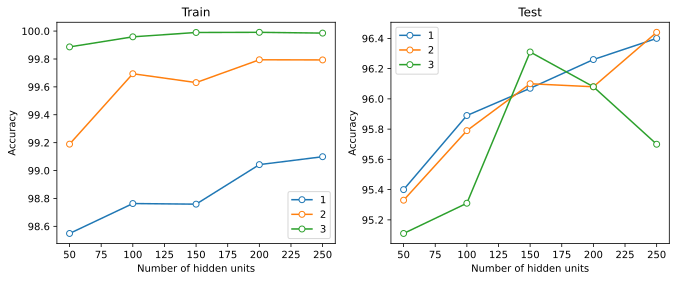

In [ ]:
# show accuracy as a function of model depth
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(numunits, accuracies[0,:,:], 'o-', markerfacecolor='w', markersize=6)
ax[1].plot(numunits, accuracies[1,:,:], 'o-', markerfacecolor='w', markersize=6)

for i in range(2):
    ax[i].legend(numlayers)
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel('Number of hidden units')
    ax[i].set_title(['Train' if i==0 else 'Test'][0])

plt.show()

# Convolution

In [ ]:
'''
* What "convolution" means for 1D, 2D, and 3D signals.
* How to interpret the results of convolution.
* Why convolution is so powerful and important in machine-learning (hint: feature-extraction and pattern-matching!).

- Edges always cause difficulties. We deal with this through padding.
- Image convolution in DL also involves downsampling. This is done via stride and pooling.
- N kernels produces an N-layer result. These layers are called "channels" but they are features not RGB.
- Use odd kernel sizes (3,5,7, etc.) to have an exact center.
- Formally, CNNs implement cross-correlation, not convolution. But it doesn't actually matter because
  the kernels are empirically learned.

'''

# Feature maps and convolution kernels

In [ ]:
'''
* The difference between feature maps and convolution kernels (aka filters).
* The definition and organization of "channels" in PyTorch.

* Kernels
- Kernels are filters that extract features from an image.
  The same kernel applied to different images will give different feature maps.
- Kernels are generally small (3x3, 5x5, 7x7).
- In DL, kernels begin random and are learned through gradient descent.
  After learning, kernels are the same for all images.
  Using pre-trained kernels is called "transfer learning."
- Kernels are not used to classify or make decisions; they are used to extract features.
  Those features are used for classification.

'''

# Convolution in code

In [ ]:
'''
* How 2D convolution is implemented manually, in scipy, and in PyTorch
* Understand the major paradigm-shift between traditonal computer vision and CNN-based computer vision.

'''

In [ ]:
# convolution
from scipy.signal import convolve2d

# to read an image from a url
from imageio import imread

## Manual 2D convolution in numpy/scipy

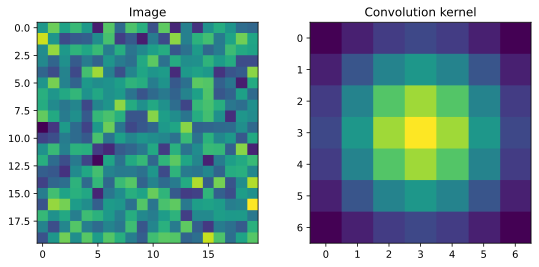

In [ ]:
# image
imgN = 20
image = np.random.randn(imgN, imgN)

# convolution kernel
kernelN = 7
Y, X = np.meshgrid(np.linspace(-3,3,kernelN), np.linspace(-3,3,kernelN))
kernel = np.exp( -(X**2+Y**2)/7 )

# let's see what they look like
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(image)
ax[0].set_title('Image')

ax[1].imshow(kernel)
ax[1].set_title('Convolution kernel')

plt.show()

In [ ]:
# now for the convolution
convoutput = np.zeros((imgN, imgN))
halfKr = kernelN // 2

for rowi in range(halfKr, imgN-halfKr):
    for coli in range(halfKr, imgN-halfKr):

        # cut out a piece of the image
        pieceOfImg = image[rowi - halfKr : rowi + halfKr + 1, :]            # get the rows
        pieceOfImg = pieceOfImg[:, coli - halfKr : coli + halfKr + 1]    # extract the columns

        # dot product: element-wise multiply and sum (and flip the kernel for "real convolution")
        dotprod = np.sum( pieceOfImg * kernel[::-1,::-1])

        # store the result for this pixel
        convoutput[rowi, coli] = dotprod

In [ ]:
# using scipy
convoutput2 = convolve2d(image, kernel, mode='valid')

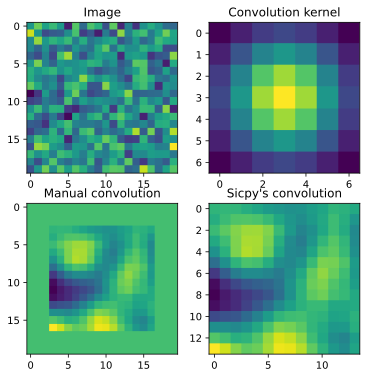

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(6,6))

ax[0,0].imshow(image)
ax[0,0].set_title('Image')

ax[0,1].imshow(kernel)
ax[0,1].set_title('Convolution kernel')

ax[1,0].imshow(convoutput)
ax[1,0].set_title('Manual convolution')

ax[1,1].imshow(convoutput2)
ax[1,1].set_title("Sicpy's convolution")

plt.show()

## Examples of convolution with different kernels in a real image

In [ ]:
# read a pic from the web
bathtub = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')

# check the size
print(bathtub.shape)

<ipython-input-9-964e7387feb2>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bathtub = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')


(1675, 3000, 3)


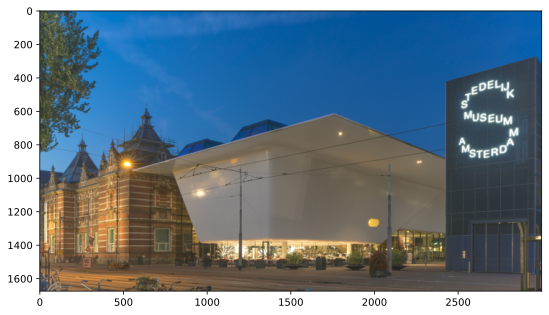

In [ ]:
# let's see what the famous Bathtub Museum looks like
fig = plt.figure(figsize=(9,6))
plt.imshow(bathtub);

In [ ]:
# transform image to 2D for convenience (not necessary for convolution!)
bathtub = np.mean(bathtub, axis=2)
bathtub = bathtub / np.max(bathtub)

# check the size again
print(bathtub.shape)

(1675, 3000)


In [ ]:
# hand-craft two convolution kernels

# vertical kernel
VK = np.array([[1,0,-1],
                        [1,0,-1],
                        [1,0,-1]])

# horizontal kernel
HK = np.array([[1,1,1],
                        [0,0,0],
                        [-1,-1,-1]])

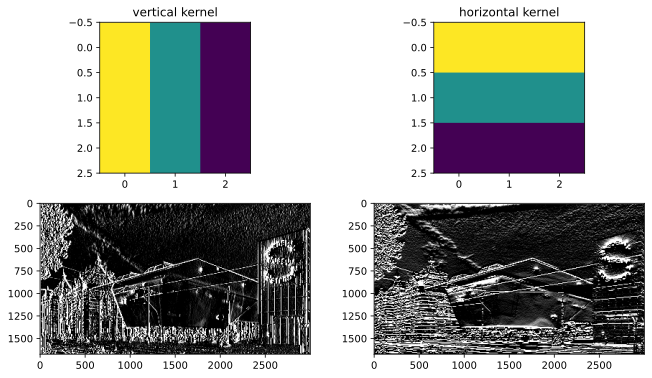

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(11,6))

ax[0,0].imshow(VK)
ax[0,0].set_title('vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('horizontal kernel')

# run convolution and show the result
convres = convolve2d(bathtub, VK, mode='same')
ax[1,0].imshow(convres, cmap='gray', vmin=0, vmax=.01)

convres = convolve2d(bathtub, HK, mode='same')
ax[1,1].imshow(convres, cmap='gray', vmin=0, vmax=.01)

plt.show()

## Now in PyTorch

In [ ]:
# first, translate everything into a tensor

VK_tensor = torch.tensor(VK).view(1,1,3,3).double()
HK_tensor = torch.tensor(HK).view(1,1,3,3).double()
bathtub_tensor = torch.tensor(bathtub).view(1,1,bathtub.shape[0], bathtub.shape[1])

print(VK_tensor.shape)
print(bathtub_tensor.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 1675, 3000])


In [ ]:
C = F.conv2d(bathtub_tensor, VK_tensor)
print(C.shape)

torch.Size([1, 1, 1673, 2998])


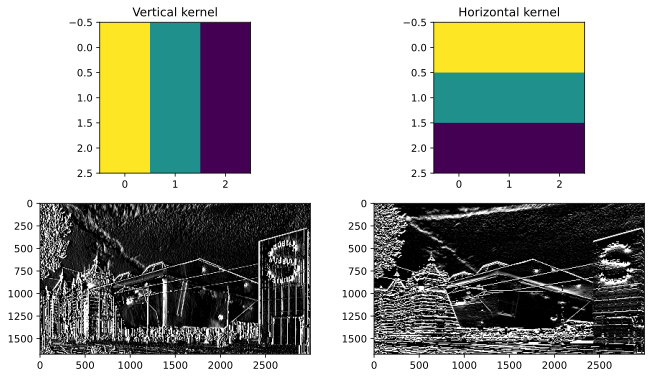

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(11,6))

ax[0,0].imshow(VK)
ax[0,0].set_title('Vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('Horizontal kernel')

# run convolution and show the result
convres = F.conv2d(bathtub_tensor, VK_tensor)
img = torch.squeeze(convres.detach())                               # torch.squeeze: squeeze singleton dimensions!
ax[1,0].imshow(img, cmap='gray', vmin=0, vmax=.01)

convres = F.conv2d(bathtub_tensor, HK_tensor)
img = torch.squeeze(convres.detach())
ax[1,1].imshow(img, cmap='gray', vmin=0, vmax=.01)

plt.show()

# Convolution parameters (stride, padding)

In [ ]:
'''
* How convolution can be used for downsampling.
* The formulas for computing the size of the result of 2D convolution.

* Convolution and padding
- Padding is used to increase the size of the result of convolution, and match with the previous layer (or image).
- Padding involves inserting 1+rows and columns.
- Added rows/columns are symmetric!
- Padded numbers are usually zeros. It's also possible to wrap the image from top-to-bottom (circular convolution).

* Convolution and stride
- Stride is used to decrease the size of the result of convolution.
  It is a mechanism of downsampling, and reduces the number of parameters in a CNN.
- The stride parameter (should have been called skip IMHO) is an integer. Stride=1 gives the full result.
- Stride is usually the same for rows and columns, but can be different when warranted.

* Padding and stride on image size: formulas
N (Number of pixels in current layer) = floor((M + 2p - k) / s) + 1

'''

# Conv2 class in PyTorch

## Create a convolution instance

In [ ]:
# create a conv2d class instance with parameters

# parameters
inChans = 3         # RGB
outChans = 15
krnSize = 5          # should be an odd number
stride = 1
padding = 0

# create the instance (cf nn.Linear)
c = nn.Conv2d(inChans, outChans, krnSize, stride, padding)

# let's have a look at it
print(c)
print()

# check out its weight tensor; what are the dimensions?
print('Size of weights: ' + str(c.weight.shape))
print('Size of bias: ' + str(c.bias.shape))

Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))

Size of weights: torch.Size([15, 3, 5, 5])
Size of bias: torch.Size([15])


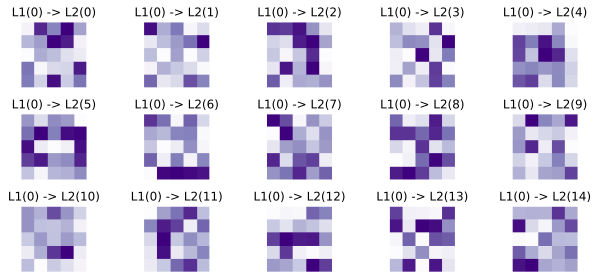

In [ ]:
# What do these kernels look like?

fig, axs = plt.subplots(3,5,figsize=(9,4))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(c.weight[i,0,:,:]).detach(), cmap='Purples')
    ax.set_title('L1(0) -> L2(%s)' %i)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Convolve with an image

torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)


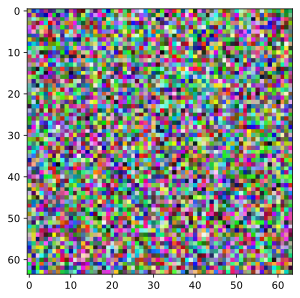

In [ ]:
# size of the image (N, RGB, width, height)
imsize = (1, 3, 64, 64)

img = torch.rand(imsize)

# pytorch wants channels first, but matplotlib wants channels last.
# therefore, tensors must be permuted to visualize
img2view = img.permute(2,3,1,0).numpy()
print(img.shape)
print(img2view.shape)

plt.imshow(np.squeeze(img2view));

In [ ]:
# convolve the image with the filter bank (set of 'outChans' kernels)
convRes = c(img)

print(img.shape)
print(convRes.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 15, 60, 60])


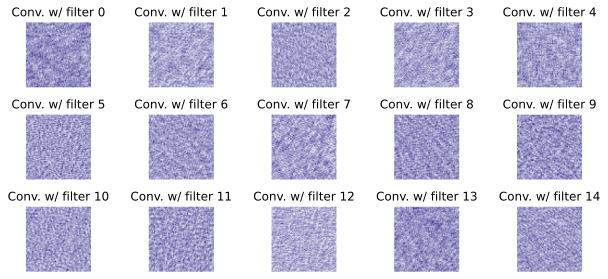

In [ ]:
# What do the convolved images look like? (Hint: think of the bathtub picture.)

fig, axs = plt.subplots(3,5,figsize=(9,4))

for i, ax in enumerate(axs.flatten()):

    # extract this "layer" of the convolution result
    I = torch.squeeze(convRes[0,i,:,:]).detach()

    # and visualize it
    ax.imshow(I, cmap='Purples')
    ax.set_title('Conv. w/ filter %s' %i)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Choose the parameters

## Convolve an image of size 1x256x256 to produce a 1x252x84 result

In [4]:
# parameters
inChans = 1 # RGB
imSize = [256,256]
outChans = 1
krnSize = 7 # should be an odd number
stride = (1,3)
padding = 1

# create the instance
c = nn.Conv2d(inChans, outChans, krnSize, stride, padding)

# create an image
img = torch.rand(1, inChans, imSize[0], imSize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape
# empSize = resimg.shape

# compute the size of the result according to the formula
expectSize = np.array([outChans, 0,0], dtype=int)
expectSize[1] = np.floor( (imSize[0] + 2*padding - krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imSize[1] + 2*padding - krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [  1 252  84]
Empirical size: [252, 84]


## Convolve an image of size 3x64x64 to produce a 10x28x28 result

In [26]:
# parameters
inChans = 3
imSize = [64,64]
outChans = 10
krnSize = 9
stride = (2,2)
padding = 0

# create the instance
c = nn.Conv2d(inChans, outChans, krnSize, stride, padding)

# create an image
img = torch.rand(1, inChans, imSize[0], imSize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans, 0,0], dtype=int)
expectSize[1] = np.floor( (imSize[0] + 2*padding - krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imSize[1] + 2*padding - krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [10 28 28]
Empirical size: [10, 28, 28]


## Convolve an image of size 3x196x96 to produce a 5x66x49 result

In [28]:
# parameters
inChans = 3
imSize = [196,96]
outChans = 5
krnSize = 5
stride = (3,2)
padding = 3

# create the instance
c = nn.Conv2d(inChans, outChans, krnSize, stride, padding)

# create an image
img = torch.rand(1, inChans, imSize[0], imSize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans, 0,0], dtype=int)
expectSize[1] = np.floor( (imSize[0] + 2*padding - krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imSize[1] + 2*padding - krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 5 66 49]
Empirical size: [5, 66, 49]


## Convolve an image of size 1x32x32 to produce a 6x28x28 result

In [37]:
# parameters
inChans = 1
imSize = [32,32]
outChans = 6
krnSize = 5
stride = (1,1)
padding = 0

# create the instance
c = nn.Conv2d(inChans, outChans, krnSize, stride, padding)

# create an image
img = torch.rand(1, inChans, imSize[0], imSize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans, 0,0], dtype=int)
expectSize[1] = np.floor( (imSize[0] + 2*padding - krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imSize[1] + 2*padding - krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 6 28 28]
Empirical size: [6, 28, 28]


## Convolve an image of size 3x227x227 to produce a 96x55x55 result

In [41]:
# parameters
inChans = 3
imSize = [227,227]
outChans = 96
krnSize = 11
stride = (4,4)
padding = 1

# create the instance
c = nn.Conv2d(inChans, outChans, krnSize, stride, padding)

# create an image
img = torch.rand(1, inChans, imSize[0], imSize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans, 0,0], dtype=int)
expectSize[1] = np.floor( (imSize[0] + 2*padding - krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imSize[1] + 2*padding - krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [96 55 55]
Empirical size: [96, 55, 55]


## Convolve an image of size 3x224x224 to produce a 64x224x224 result

In [42]:
# parameters
inChans = 3
imSize = [224,224]
outChans = 64
krnSize = 3
stride = (1,1)
padding = 1

# create the instance
c = nn.Conv2d(inChans, outChans, krnSize, stride, padding)

# create an image
img = torch.rand(1, inChans, imSize[0], imSize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans, 0,0], dtype=int)
expectSize[1] = np.floor( (imSize[0] + 2*padding - krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imSize[1] + 2*padding - krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 64 224 224]
Empirical size: [64, 224, 224]


# Transpose convolution

In [ ]:
'''
* What transpose convolution means and why it's important for autoencoders.
* How transpose convolution is used for upsampling.
* How to implement transpose convolution in PyTorch.

- Transpose convolution means to scalar-multiply a kernel by each pixel in an image.
- As long as the kernel is > 1 pixel, the result will be higher resolution than the original image.
- Transpose convolution is used for autoencoders and super-resolution CNNs.
- Transpose convolution takes the same parameters as "forward" convolution: kernel size, padding, stride.

* Size of transpose convolution size
N = s * (M-1) + k -2p

'''

## Create a transpose convolution instance

In [44]:
# create a ConvTranspose2d class instance with parameters

# parameters
inChans = 3
outChans = 15
krnSize = 5
stride = 1
padding = 0

# create the instance
c = nn.ConvTranspose2d(inChans, outChans, krnSize, stride, padding)

# let's have a look at it
print(c)
print()

# check out its weight tensor; what are the dimensions?
print('Size of weighs: ' + str(c.weight.shape))
print('Size of bias: ' + str(c.bias.shape))

# tip: compare the sizes of these weights with those of "forward" convolution

ConvTranspose2d(3, 15, kernel_size=(5, 5), stride=(1, 1))

Size of weighs: torch.Size([3, 15, 5, 5])
Size of bias: torch.Size([15])


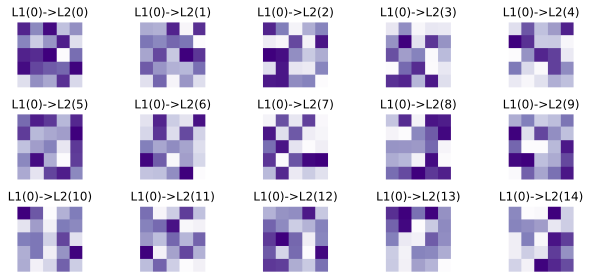

In [46]:
# What do these kernels look like?
fig, axs = plt.subplots(3,5,figsize=(9,4))

for i, ax in enumerate(axs.flatten()):

    ax.imshow(torch.squeeze(c.weight[0,i,:,:]).detach(), cmap='Purples')
    ax.set_title('L1(0)->L2(%s)' %i)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Convolve with an image

In [47]:
# size of the image (N, RGB, width, height)
imsize = (1,3,64,64)

img = torch.rand(imsize)

# pytorch wants channels first, but matplotlib wants channels last.
# therefore, tensor must be permuted to visualize
img2view = img.permute(2,3,1,0)
print(img.shape)
print(img2view.shape)

torch.Size([1, 3, 64, 64])
torch.Size([64, 64, 3, 1])


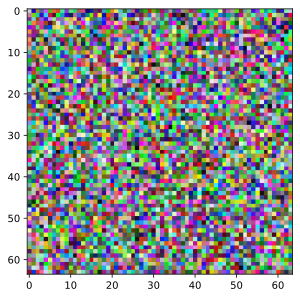

In [49]:
plt.imshow(np.squeeze(img2view));

In [50]:
# convolve the image with the filter bank (set of "outChans" kernels)
convRes = c(img)

print(img.shape)
print(convRes.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 15, 68, 68])


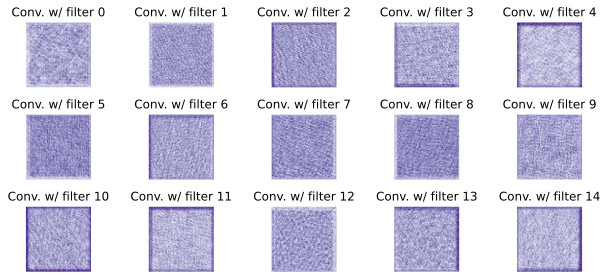

In [52]:
# What do the convolved images look like? (Hint: think of the bathtub picture.)
fig, axs = plt.subplots(3,5,figsize=(9,4))

for i, ax in enumerate(axs.flatten()):

    # extract this "layer" of the convolution result
    I = torch.squeeze(convRes[0,i,:,:]).detach()

    # and visualize it
    ax.imshow(I, cmap='Purples')
    ax.set_title('Conv. w/ filter %s' %i)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Max/mean pooling

In [ ]:
'''
* Why use a pooling layer?
- Reduces dimensionality (fewer parameters).
- Selects for features over a broader spatial area (increased "receptive field" size).
- Deeper into the model, we want more channels with fewer pixels. This makes the representations increasingly abstract.

# Max or mean?
- Max pooling: Highlihgts sharp features.
  Useful for sparse data and increasing contrast.
- Mean pooling: Smooths images (it's a low-pass filter).
  Useful for noisy data and to reduce the impact of outliers on learning.

* What are receptive fields?
- ANNs have a one-to-one mapping between pixel and unit.
  In other words, the receptive field of an ANN unit is one pixel.
- This makes the model non-robust to translations, resizing, rotations, etc.
- We want a model that can "see" the features anywhere in the image.

* CNN with pooling: Each layer sees more of the image.

* What about deep ANNs?
- Sufficiently deep ANNs wll also work "just as well" (because of the universal approxiation theorem).
- But they will be much more complex, have many more parameters, and will be much harder to train.
- CNNs are a more efficient architecture for certain kinds of problems, namely image categorization.

'''

In [52]:
'''
* The goals of pooling
- Pooling reduces the spatial size of the image with each succesive network layer.
- Pooling allows the model to detect one feature anywhere in the image (increased receptive field size).

* Parameters of pooling
- Spatial extent ("kernel size"): The number of pixels in the pooling window.
  Typically set to 2 (actually 2x2).
- Stride: The number of pixels to skip for each window.
  Typically set to 2 (produces no overlap).
- Can also use (3,3). Setting stride < kernel creates overlapping windows, which is less common.

'''

## Create a maxpool instance

In [55]:
# create a pool class instance with parameters

# parameters
poolSize = 3
stride = 3

# create the instance
p2 = nn.MaxPool2d(poolSize, stride=stride)
p3 = nn.MaxPool3d(poolSize, stride=stride)

# let's have a look at them
print(p2)
print(p3)

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [57]:
# Create image and apply maxpooling

# create a 2D and a 3D image
img2 = torch.randn(1,1,30,30)
img3 = torch.randn(1,3,30,30)

# all combinations of image and maxpool dimensionality
img2Pool2 = p2(img2)
print(f'2D image, 2D maxpool: {img2Pool2.shape}\n')

# img2Pool3 = p3(img2)
# print(f'2D image, 3D maxpool: {img2Pool3.shape}\n')

img3Pool2 = p2(img3)
print(f'3D image, 2D maxpool: {img3Pool2.shape}\n')

img3Pool3 = p3(img3)
print(f'3D image, 3D maxpool: {img3Pool3.shape}')

2D image, 2D maxpool: torch.Size([1, 1, 10, 10])

3D image, 2D maxpool: torch.Size([1, 3, 10, 10])

3D image, 3D maxpool: torch.Size([1, 1, 10, 10])


## Create a simple CNN

In [58]:
littlenet = nn.Sequential(

                          ## the conv-pool block
                          nn.Conv2d(3,10,5,3,2),                # convolution layer
                          nn.ReLU(),                                   # activation function
                          nn.AvgPool3d(3,3),                      # average-pool

                          ## the FFN block
                          nn.Flatten(),                                 # vectorize to get from image to linear
                          nn.Linear(588,1),                         # FC linear layer
                          nn.Sigmoid()                                # output activation
)

In [59]:
# test with a bit of data
img = torch.rand(1,3,128,128)
littlenet(img)

tensor([[0.4533]], grad_fn=<SigmoidBackward0>)

In [63]:
littlenet

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool3d(kernel_size=3, stride=3, padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=588, out_features=1, bias=True)
  (5): Sigmoid()
)

# To pool or to stride?

In [ ]:
'''
* The difference between pooling vs. stride for downsampling images during convolution.

1) Pooling
- Computationally fast
- No parameters
- Kernel spans a smaller area (smaller receptive fields)
- Highly stable

2) Stride
- Somewhat slower
- Learned parameters
- Kernel spans a larger area (larger receptive fields)
- Can be unstable in complex architectures

'''

# Image transforms

In [ ]:
'''
* The two motivations for applying transforms to images in CNNs.

- Pre-trained CNNs are coded for certain image sizes.
  Yout might need to resize your images to work, or convert to grayscale.
- Transforming images changes raw pixel values without changing the image information.
  Transforms are thus a way to increase the total amount of data.

'''

## Import a dataset

In [ ]:
# The list of datasets that come with torchvision: https://pytorch.org/vision/stable/index.html

In [64]:
# download the CIFAR10 dataset
cdata = torchvision.datasets.CIFAR10(root='cifar10', download=True)

cdata

100%|██████████| 170498071/170498071 [00:03<00:00, 54687899.62it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train

In [65]:
# check out the shape of the dataset
print(cdata.data.shape)

(50000, 32, 32, 3)


In [66]:
# the unique categories
print(cdata.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [67]:
# .targets is a list of targets converted to ints
print(len(cdata.targets))

50000


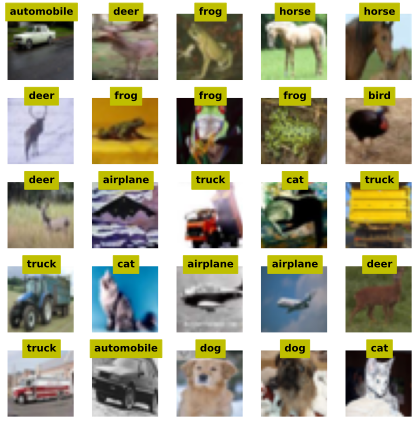

In [69]:
# inspect a few random images
fig, axs = plt.subplots(5,5, figsize=(6,6))

for ax in axs.flatten():

    # select a random picture
    rand_idx = np.random.choice(len(cdata.targets))

    # extract that image
    pic = cdata.data[rand_idx, :,:,:]
    # and its label
    label = cdata.classes[cdata.targets[rand_idx]]

    # and show!
    ax.imshow(pic)
    ax.text(16,0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Apply some transformations

In [71]:
Ts = T.Compose([
    T.ToTensor(),
    T.Resize(32*4),
    T.Grayscale(num_output_channels=1)
])

# include the transform in the dataset
cdata.transform = Ts

# you can also apply the transforms immediately when loading in the data
# cdata = torchvision.datasets.CIFAR10(root='cifar10', download=True, transform=Ts)

In [72]:
# Important! Adding a transform doesn't change the image data:
print(cdata.data[123,:,:,:].shape)

(32, 32, 3)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


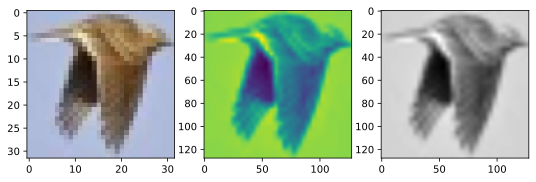

In [73]:
# apply the transform

# option 1 : apply the transform "externally" to an image
img1 = Ts( cdata.data[123,:,:,:] )

# option 2 : use the embeded transform
img2 = cdata.transform( cdata.data[123,:,:,:] )

# let's see what we've done!
fig, ax = plt.subplots(1,3,figsize=(9,4))

ax[0].imshow(cdata.data[123,:,:,:])
ax[1].imshow(torch.squeeze(img1))
ax[2].imshow(torch.squeeze(img2), cmap='gray')

plt.show()

In [74]:
print(img1.shape)

torch.Size([1, 128, 128])


In [76]:
# Note about ToTensor() and normalization:
??T.ToTensor

# Creating and using custom DataLoaders

In [ ]:
'''
* Why and when you need to create custom DataSets.
* How to make your own custom DataSet class.
* How image transformations are applied during learning.

Custom(data, labels) Transformations defined here. -----> DataLoader -----> Minibatch (X,y) Transformations applied here.

* Order of operations when applying transformation
1) Import the data
2) Create a custom DataSet class.
3) Define the transformations.
4) Create a DataSet with your data and transformation.
5) Create a DataLoader (same as usual).

1) + 2) => Import a torchvision dataset that alreaedy allows added transformations.

'''

In [ ]:
# FYI, review paper on data augmentation in DL:
# https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

## Import the data

In [77]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract only the first 8
labels = data[:8,0]
data = data[:8,1:]

dataNorm = data / np.max(data)

# reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1,28,28)

# check sizes
print(dataNorm.shape)
print(labels.shape)

# convert to torch tensor format
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

(8, 1, 28, 28)
(8,)


## Create a new class to create our custom dataset type

In [81]:
# My custom dataset class is modeled after the official class
??torch.utils.data.TensorDataset

In [82]:
class customDataset(Dataset):
    def __init__(self, tensors, transform=None):

        # check that sizes of data and labels match
        assert all(tensors[0].size(0) == t.size(0) for t in tensors), "Size mismatch between tensors"

        # assign inputs
        self.tensors = tensors
        self.transform = transform

    # what to do when someone wants an item from the dataset
    def __getitem__(self, index):

        # return transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else:
            x = self.tensors[0][index]

        # and return label
        y = self.tensors[1][index]

        return x, y # return the (data, label) tuple

    def __len__(self):
        return self.tensors[0].size(0)

## data -> dataset -> dataloader

In [83]:
# Note: several transforms work only on PIL-format data,
# so it's common to transform to PIL, apply transformations, then transform back to tensor.

# create a list of transforms to apply to the image
img_trans = T.Compose([
                                        T.ToPILImage(),
                                        T.RandomVerticalFlip(p=.5),
                                        # T.RandomRotation(90),
                                        T.ToTensor()
])

In [84]:
# now convert the data into datasets and then dataloaders

# convert into PyTorch Datasets
# NOTE: we have no test data here, but you should apply the same transformations to the test data
train_set = customDataset((data_tensor, labels_tensor), img_trans)

# translate into dataloader objects
train_loader = DataLoader(train_set, batch_size=8, shuffle=False)

In [85]:
type(train_set)

__main__.customDataset

## Let's the effects!

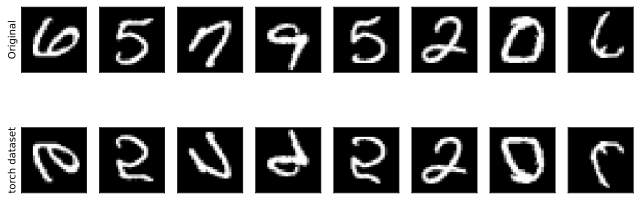

In [87]:
# import data from the dataloader, just like during training
X, y = next(iter(train_loader))

# create a figure
fig, axs = plt.subplots(2,8,figsize=(11,4))

# loop over images in the dataset
for i in range(8):

    # draw images
    axs[0,i].imshow(data_tensor[i,0,:,:].detach(), cmap='gray')
    axs[1,i].imshow(X[i,0,:,:].detach(), cmap='gray')

    # some niceties
    for row in range(2):
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])

# row labels
axs[0,0].set_ylabel('Original')
axs[1,0].set_ylabel('torch dataset')

# plt.tight_layout()
plt.show()

In [89]:
# Important to know: we haven't actually increased the amount of data
len(train_set)

8